# 目标检测

边缘框
- 一个边缘框可以通过4个数字定义
  - (左上x，左下y，右下x，右下y)
  - (左上x，左上y，宽，高)

目标检测数据集
- 每**行**表示一个物体
  - **图片文件名，物体类别，边缘框**
- COCO（cocodataset.org）
  - 80物体，330K图片，1.5M物体

### 总结
- 物体检测识别图片里的多个物体的类别和位置
- 位置通常用边缘框表示



## 代码

In [27]:
!pip install d2l

In [28]:
import torch

from d2l import torch as d2l

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- `plt.imread('图像文件路径')`用于将图像文件读取为numpy格式

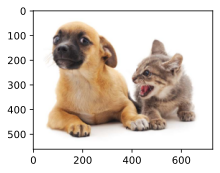

In [29]:
d2l.set_figsize()
img = d2l.plt.imread('/content/drive/MyDrive/Colab Notebooks/img/catdog.jpg')
d2l.plt.imshow(img)

#### 边界框
**定义在两种表示法之间进行转换的函数**
- `boxes`是长度为4的张量，也可以是形状为`(n, 4)`的二维张量，其中`n`是边界框的数量

In [6]:
def box_corner_to_center(boxes):
  x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:,3]
  cx = (x1 + x2) / 2
  cy = (y1 + y2) / 2
  w = x2 - x1
  h = y2 - y1
  boxes = torch.stack((cx, cy, w, h), axis=1)
  return boxes    # 输出形状同样是`(N, 4)`

def box_center_to_corner(boxes):
  cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
  x1 = cx - 0.5 * w
  y1 = cy - 0.5 * h
  x2 = cx + 0.5 * w
  y2 = cy + 0.5 * h
  boxes = torch.stack((x1, y1, x2, y2), axis=1)
  return boxes

**根据坐标信息，定义图像中狗和猫的边界框**

In [4]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

In [7]:
boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

**将边框在图中画出**
- **`matplotlib.patches.Ractangle(xy, width, height, fill, edgecolor, linewdth)`**用于创建矩形对象
- **`add_patch`**是`matplotlib.axes.Axes`对象的方法，用于将一个`patch`添加到图像中

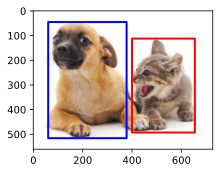

In [8]:
def bbox_to_rect(bbox, color):
  return d2l.plt.Rectangle(
    xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
    fill=False, edgecolor=color, linewidth=2
  )

fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

### 练习

1. 找到另一张图像，然后尝试标记包含该对象的边界框。比较标注边界框和标注类别哪个需要更长的时间？

In [38]:
d2l.set_figsize()
img = d2l.plt.imread('/content/drive/MyDrive/Colab Notebooks/img/cat2.jpg')

cat_bbox = [552., 335, 848, 1076]
boxes = torch.tensor([cat_bbox])
d2l.box_center_to_corner(d2l.box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True]])

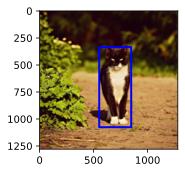

In [37]:
figure = d2l.plt.imshow(img)
figure.axes.add_patch(d2l.bbox_to_rect(cat_bbox, 'blue'))

2. 为什么`box_center_to_corner`和`box_corner_to_center`的输入参数的最内层维度总是4？
- 答
  - 因为通常使用的边界框表示形式是基于矩形框的四个角点或中心点来定义的


# 目标检测数据集

d2l收集并标记了一个小型数据集

**下载并读取数据集**

In [2]:
import os
import pandas as pd
import torch
import torchvision

from d2l import torch as d2l

- DATA_HUB存储了数据集的URL地址和哈希值信息

In [12]:
d2l.DATA_HUB['banana-detechion'] = [
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72'
]

DATA_HUB = d2l.DATA_HUB

- `name`要在`DATA_HUB`字典中作为键
- `cache_dir`表示默认的下载目录
- `request.get(url, stream=True, verify=True)`发送HTTP GET请求以下载文件
- `r.content`类型是 bytes，表示二进制数据，包含从URL下载的文件的全部数据
- `f.write()`将所有内容直接写入文件，保持数据完整性
- `os.path.dirnmae()`获取下载文件的*目录路径*
- `os.path.dirnmae()`获取*文件路径*的`data_dir`和`ext`文件扩展名

In [39]:
import hashlib
import os
import requests
import tarfile
import zipfile

data_dir_drive = '/content/drive/My Drive/ColabData/'

def download(name, cache_dir=os.path.join(data_dir_drive, 'data')):
  assert name in DATA_HUB, f"{name}不存在于{DATA_HUB}中。"
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()  # 创建一个SHA-1哈希对象
    with open(fname, 'rb') as f:
      while True:
        data = f.read(1048576)  # 以每次 1 MB 的块大小读取
        if not data:  # data为空，文件读取完毕
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname # 文件已经存在且完整
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

def download_extract(name, folder=None):
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    with zipfile.ZipFile(fname, 'r') as z:
      z.extractall(base_dir)  # 解压`zip`文件中所有内容，并放在`base_dir`路径下
  elif ext in ('.tar', '.gz'):
    with tarfile.open(fname, 'r') as t:
      t.extractall(base_dir)
  else:
    raise ValueError('只有zip/tar文件可以被解压缩。')
  return os.path.join(base_dir, folder) if folder else data_dir

#### 读取香蕉检测数据集的函数
- **标号方式**还是很关键的
- 此数据集包括一个CSV文件，*内含*目标类别标签和位于左上角和右下角的真实边界框坐标

- `.set_index('img_name')`将列设为索引，通过图像名称索引标签信息
- `.iterrows()`是pandas库，专门用于`DataFrame`对象，逐行遍历`DataFrame`中的行，返回每一行的索引和行数据
- `torchvision.io.read_images(path)`用于读取图像文件，并将其转换为pytorch张量
  - `torch.datasets.ImageFolder`只能读取一个文件夹，其中每个文件夹对应一个**类别**
- `.unsqueeze(1)`在维度1添加一个新维度
  - 通过增加这个维度，可以在后续处理中保持与图像批次结构一致

In [40]:
def read_data_bananas(is_train=True):
  data_dir = download_extract('banana-detechion')
  csv_fname = os.path.join(
    data_dir,
    'bananas_train' if is_train else 'bananas_val',
    'label.csv'
  )
  csv_data = pd.read_csv(csv_fname)
  csv_data = csv_data.set_index('img_name')
  images, targets = [], []
  for img_name, target in csv_data.iterrows():
    images.append(
      torchvision.io.read_image(
        os.path.join(
          data_dir, 'bananas_train' if is_train else 'bananas_val',
          'images', f'{img_name}'
        )
      )
    )
    targets.append(list(target))
  return images, torch.tensor(targets).unsqueeze(1) / 256  # 将目标检测框的坐标归一化到[0,1]范围

#### **创建一个自定义的Dataset实例**
- 定义`BananasDataset`类，继承自`torch.utils.data.Dataset`，使得该类能被数据加载器`DataLoader`使用
- 继承`Dataset`，需要实现**`__len__`**和**`__getitem__`**方法

In [41]:
class BananasDataset(torch.utils.data.Dataset):
  def __init__(self, is_train):
    self.features, self.labels = read_data_bananas(is_train)
    print(
      'read' + str(len(self.features)) +
      ('training examples' if is_train else 'validation examples')
    )

  def __getitem__(self, idx):
    return (self.features[idx].float(), self.labels[idx])

  def __len__(self):
    return len(self.features)

#### 为训练集和测试集返回两个**数据加载器实例**

In [8]:
def load_data_bananas(batch_size):
  train_iter = torch.utils.data.DataLoader(
    BananasDataset(is_train=True), batch_size, shuffle=True
  )
  val_iter = torch.utils.data.DataLoader(
    BananasDataset(is_train=False), batch_size
  )
  return train_iter, val_iter

#### **读取一个小批量，并打印其中的图像和标签的形状**
- 图像的小批量形状（批量大小，通道数，高度，宽度）
- 标签的小批量形状（批量大小，m，5）
  - m是数据集的任何图像中边界框可能出现的最大数
- 小批量计算：
  - **要求每张图像含有相同数量的边界框**， 以便放在同一批量中
    - 在达到`m`之前，边界框少于`m`的图像将被非法边界框填充
    - 则每个边界框的标签将被长度为5的数组表示
      - 数组第一个元素使边界框对象的类别，用`-1`表示用于填充的非法边界框
      - 其余四个元素使左上角和右下角的坐标值
  - 对于香蕉数据集而言，由于每张图像上只有一个边界框，因此`m=1`

In [25]:
batch_size, edge_size = 32, 256
train_iter, test_iter = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read1000training examples
read100validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

**演示**
- **`tensor.permute(dim0, dim1, dim2...)`**是`Tensor`对象的一个方法，用于*重新排列张量的维度顺序*
- 除法仅作用于**像素的数值**，并不改变张量的结构或维度
- `label[0]`表示`label`中的*第一组标签*，包含图像中物体的类别和边框信息

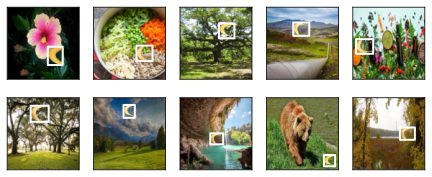

In [44]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=1.5)
for ax, label in zip(axes, batch[1][0:10]):
  d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

### 练习

1. 在香蕉检测数据集中演示其他带有真实边界框的图像。它们在边界框和目标方面有什么不同？

In [45]:
train_iter, _ = d2l.load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

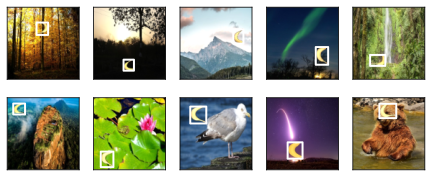

In [46]:
imgs = (batch[0][11:21].permute(0, 2, 3, 1)) / 225
axes = d2l.show_images(imgs, 2, 5, scale=1.5)
for ax, label in zip(axes, batch[1][11:21]):
  d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

2. 假设我们想要将数据增强（例如随机裁剪）应用于目标检测。它与图像分类中的有什么不同？提示：如果裁剪的图像只包含物体的一小部分会怎样？
- 答
  - 目标完整性
  - 边界框更新
  - 多对象处理